A common argument I've been running into with more junior data scientists is about the effect of model selection on the performance of their model.  We're taught that cross-validation produces unbiased estimates of the model performance (well, in fact it's the model performance conditional on the observed data, see [Bates, Hastie, and Tibshirani](https://arxiv.org/pdf/2104.00673.pdf)).  However, what they don't realize is that they've used cross-validation for model selection and so the chosen model has already been optimized for the given data, and so any inferential statistics or model performance will be biased, a form of data leakage.  

In [1]:
import base64, io, IPython
from PIL import Image as PILImage
image_path = 'cv_meme.png'
image = PILImage.open(image_path)

output = io.BytesIO()
image.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:cv_meme.jpg;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

To better illustate this point, I constructed an extreme example of overfitting where the labels and features have no relationship.  Specifically, the data is 10,000 data points of 2500x4 dimensions, all independent standard normal random variables.  The labels are independent random Bernoulli with probability of success equal to 0.02.  This imbalanced class problem is typical of realistic problems, such as fraud detection, where alleviating the imbalance (e.g. by oversampling the minority class) contributes to overfitting.   The notebook [`pytorch_you_need_a_test_set.ipynb`](https://github.com/timydaley/timydaley.github.io/blob/main/you_need_a_test_set/pytorch_you_need_a_test_set.html) contains the code for data generation and model fitting using cross-validation.

I fit different 3-layer convolutional neural networks with Adam, varying the parameters weight decay, learning rate, batch size, dropout, convolution size, number of epochs, size of the second layer, minority class upsampling, and kernel size.  Each was given 2 options, for a total of $2^9 = 512$ total models.

So what happens if we use cross-validation to choose the hyperparameters, as well as evaluate the model?

In [2]:
import pandas as pd
import numpy as np
import seaborn 
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
cv = pd.read_csv('_params_running.csv')
print(cv.shape)
cv.head(3)

(512, 24)


,Unnamed: 0,n_epochs,weight_decay,learning_rate,batch_size,dropout,conv_size,model_name,layer2,upsample_frac,kernel_size,train_precision_score,train_recall_score,train_f1_score,train_pr_auc_score,train_roc_auc_score,train_conf_matrix,val_precision_score,val_recall_score,val_f1_score,val_pr_auc_score,val_roc_auc_score,val_conf_matrix,time
0,0,10,0.01,0.001,2,0.0,5,3layer,10,0.0,5,0.997845,0.997061,0.997447,0.999977,0.998511,[[ 142.6 23.8]\n [ 32.4 10991.8]],0.020805,0.990476,0.040754,0.053261,0.998511,[[1.9000e+01 1.9394e+03]\n [4.0000e-01 4.1200e...,1040.288389
1,1,10,0.01,0.001,2,0.0,5,3layer,10,0.0,10,0.997180,0.998404,0.997788,0.999976,0.998420,[[ 135.2 31.2]\n [ 17.6 11006.6]],0.020665,0.985714,0.040480,0.034267,0.998420,[[1.540e+01 1.943e+03]\n [6.000e-01 4.100e+01]],1048.174471
2,2,10,0.01,0.001,2,0.0,5,3layer,10,0.3,5,0.997537,0.999165,0.998350,0.999970,0.998069,[[1.3920e+02 2.7200e+01]\n [9.2000e+00 1.1015e...,0.020875,0.995238,0.040893,0.031782,0.998069,[[1.6600e+01 1.9418e+03]\n [2.0000e-01 4.1400e...,1052.530693


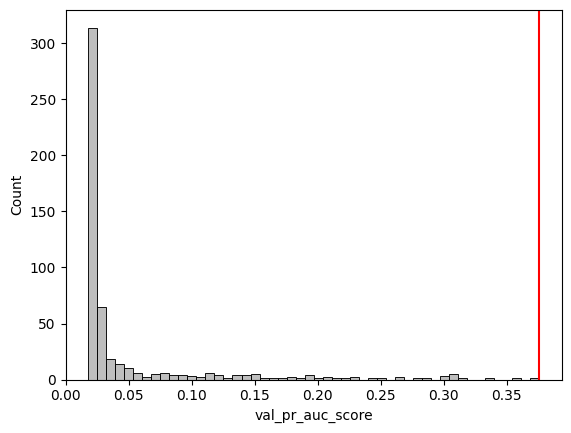

In [3]:
best_model_pr_auc_score = cv['val_pr_auc_score'].idxmax()
seaborn.histplot(cv['val_pr_auc_score'], bins = 50, color = 'darkgrey')
plt.axvline(cv.loc[best_model_pr_auc_score, 'val_pr_auc_score'] , 0, 1, color = 'red')

In [4]:
print("max CV validation PR-AUC: ", cv['val_pr_auc_score'].max())
print("average CV validation PR-AUC: ", cv['val_pr_auc_score'].mean())
print("ratio: ", cv['val_pr_auc_score'].max()/cv['val_pr_auc_score'].mean())

max CV validation PR-AUC:  0.3756869196891784
average CV validation PR-AUC:  0.048356046371190994
ratio:  7.769181888968507


In [5]:
# what's the expected PR-AUC?
from sklearn.metrics import precision_recall_curve, auc
n_bootstraps = 100
np.random.seed(12345)
N = 10000 
d = 2500
y = pd.Series(np.random.binomial(n = 1, p = 0.02, size = N))
rand_pr_auc = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    rand_classifier = np.random.uniform(low=0, high=1, size=N)
    precision, recall, thresholds = precision_recall_curve(y, rand_classifier)
    rand_pr_auc[i] = auc(recall, precision)
print("average pr_auc of a random classifier: ", np.mean(rand_pr_auc))
print("ratio of estimates PR-AUC to random PR-AUC: ", cv['val_pr_auc_score'].max()/np.mean(rand_pr_auc))

average pr_auc of a random classifier:  0.021396260533606007
ratio of estimates PR-AUC to random PR-AUC:  17.558531739651713


If we were to use the cross validation PR-AUC score for both model choice and evaluation then we would overestimate the PR-AUC by almost 8x over the average PR-AUC and over 17x the PR-AUC of a random classifier. The latter is more applicable here because of the long tail in our distribution, showing how easy it was for the classifier to overfit, even within the structure of cross-validation.    

Of course, this is an extreme example specifically designed to show the dangers of double dipping with cross validation.  But we have to understand that typically the more hyperparameter tuning that is done with cross validation, the less we can trust the performance estimates that we obtain from cross validation.  Which is why I always recommend a test set that has not been touched or peeked at in way to ensure that our performance estimates are unbiased and trustworthy.  